
The goal of the notebook is to study how we can merge NN Model and TF Gradient Boosted Trees.
Unfortunately, TF Gradient Boosted trees (TF GBT) can not be directly trained in parallel with functional API.
TF labs told me that TF GBT was trained in only 1 epoch and could only be trained with NN in 2 consecutive steps...
So the only way to proceed is to get one of the layers of a NN Model already trained and includes it into 
the argument (input) of TF GBT as "preprocessing features". Then we can train the TF GBT with the NN layers already trained. 
You will find in the notebook a training in 3 kfolds for the NN and TF GBT alone and the (NN model + TF GBT) results.

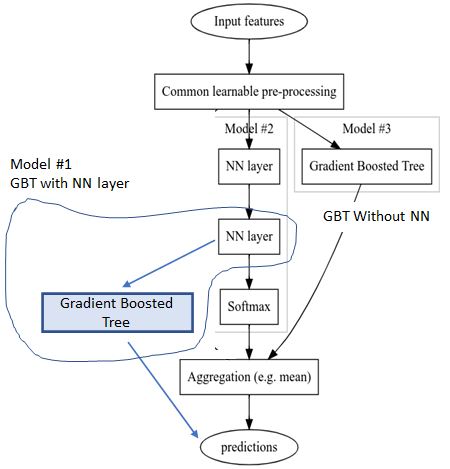

In [ ]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes
import os
import matplotlib.pyplot as plt
import math 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from keras.models import Sequential
import keras 
from keras.layers import Dense, Dropout,Concatenate, Activation,Input
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [ ]:

train_df = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')

<h2> Training parameters

In [ ]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()
metrics=tf.keras.metrics.SparseCategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0000001, patience=2, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=0, verbose=0,
    mode='min', min_delta=0.0000001, cooldown=0, min_lr=10e-7)


In [ ]:
# data for final prediction :
test1_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.iloc[:,1:])

# features for preprocessing :
features = [col for col in train_df.iloc[:,1:].columns]
target = pd.get_dummies(train_df.iloc[:,-1])

<h1> Training with 3 Folds of all models

In [ ]:

N_FOLDS = 3
SEED = 2021

oof_NN = np.zeros((train_df.shape[0],4))
pred_NN = np.zeros((test_df.shape[0],4))
oof_GBT_NN = np.zeros((train_df.shape[0],4))
pred_GBT_NN = np.zeros((test_df.shape[0],4))
oof_GBT = np.zeros((train_df.shape[0],4))
pred_GBT = np.zeros((test_df.shape[0],4))

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train_df.iloc[:,1:],train_df.iloc[:,-1])):
    
    print(f"\n======== FOLD {fold} TRAINING  =========\n")
       
    x_tr = train_df.iloc[:,1:].iloc[tr_idx]
    y_tr = train_df.iloc[:,-1].iloc[tr_idx]
    x_ts = train_df.iloc[:,1:].iloc[ts_idx]
    y_ts = train_df.iloc[:,-1].iloc[ts_idx]

    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(x_tr, label='target')
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(x_ts, label='target')
    
    #---------- NN model  preprocessing ----------
    Normalization = tf.keras.layers.experimental.preprocessing.Normalization
    nn_raw_inputs = []
    nn_processed_inputs = []
    for col in features[:-1] :

        inp = tf.keras.Input(shape=(1,),name = col)
        nn_raw_inputs.append(inp)
        
        values = train_df[col].values
        input_normalizer = Normalization()
        input_normalizer.adapt(values)
        normalized_input = input_normalizer(inp)
        nn_processed_inputs.append(normalized_input)
    
    #---------- NN model definition ----------------
    
    y = tf.keras.layers.Concatenate()(nn_processed_inputs)
    y = tf.keras.layers.Dense(128, activation='relu')(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    GBT_layer = tf.keras.layers.Dense(128, activation='relu')(y)
    y = tf.keras.layers.Dropout(0.3)(GBT_layer)
    y = tf.keras.layers.Dense(16, activation='sigmoid')(y)
    output = tf.keras.layers.Dense(4,activation = 'softmax')(y)
    
    nn_model = tf.keras.models.Model(nn_raw_inputs, output)
   
    
    #------- Model preparation for GradientBoostedTrees ----
    
    nn_model_without_head = tf.keras.models.Model(inputs=nn_model.inputs,
                                            outputs=GBT_layer)
    
    #******** Gradient Boosted Trees with NN *******************  
    # with "preprocessing=nn_model_without_head" you link the 2 models.
    
    model_Gradient_with_NN = tfdf.keras.GradientBoostedTreesModel(
    preprocessing=nn_model_without_head) # Prepocessing with NN model 
    
    #---------- Gradient Boosted Trees without NN-----------
    
    model_Gradient_without_NN = tfdf.keras.GradientBoostedTreesModel()
    
    #---------- NN Training --------------------------------
    print("\nTraining of NN model starting\n")
    nn_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                                            loss=loss ,
                                            metrics=metrics)
    nn_model.fit(train_ds,
            validation_data=test_ds,
            epochs=20,
            verbose=0,
            callbacks=[es,plateau])
    
    #-------- Gradient Boosted Trees with NN Training ------
    print("\nTraining of GBT with NN model starting\n")
    model_Gradient_with_NN.compile(metrics=metrics)
    model_Gradient_with_NN.fit(train_ds)
    
    # Training display
    print()
    logs = model_Gradient_with_NN.make_inspector().training_logs()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")
    plt.title("GBT with NN training")
    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")
    plt.title("GBT with NN training")
    plt.show()
    
    #------- Gradient Boosted Trees without NN Training -----
    print("\nTraining of GBT without NN model starting\n")
    model_Gradient_without_NN.compile(metrics=metrics)
    model_Gradient_without_NN.fit(train_ds)
    
    # Training display
    print()
    logs = model_Gradient_without_NN.make_inspector().training_logs()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")
    plt.title("GBT alone training")
    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")
    plt.title("GBT alone training")
    plt.show()
    
    #------------------- NN Prediction -------------------
    
    oof_NN[ts_idx] = nn_model.predict(test_ds)
    pred_NN += nn_model.predict(test1_ds) / N_FOLDS
    score_NN = log_loss(y_ts, oof_NN[ts_idx])
    print(f"Score of NN alone {score_NN}\n")
    
    #---Gradient Boosted Trees with NN Prediction --------
    
    oof_GBT_NN[ts_idx] = model_Gradient_with_NN.predict(test_ds)
    pred_GBT_NN += model_Gradient_with_NN.predict(test1_ds) / N_FOLDS
    score_GBT_NN = log_loss(y_ts, oof_GBT_NN[ts_idx])
    print(f"Score of GBT with NN {score_GBT_NN}\n")
    
    #---Gradient Boosted Trees without NN Prediction ------
    
    oof_GBT[ts_idx] = model_Gradient_without_NN.predict(test_ds)
    pred_GBT+= model_Gradient_without_NN.predict(test1_ds) / N_FOLDS
    score_GBT = log_loss(y_ts, oof_GBT[ts_idx])
    print(f"Score of GBT alone {score_GBT}\n")
    
score_NN = log_loss(train_df.iloc[:,-1], oof_NN)
score_GBT_NN = log_loss(train_df.iloc[:,-1], oof_GBT_NN)
score_GBT = log_loss(train_df.iloc[:,-1], oof_GBT)
print("\n========== FINAL SCORES =================\n")
print(f"Score total of NN alone {score_NN}\n")
print(f"Score total of GBT with NN  {score_GBT_NN}\n")
print(f"Score total of GBT alone {score_GBT}\n")

<h3>It leads quickly to overfitting with the standard parameters and don't give better result for NN...but maybe with a fine tuning it can...I let you play with it :-)

In [ ]:
"""
**To get all the parameters description :

?tfdf.keras.GradientBoostedTreesModel

**To get verbose = 1 for GBT :

with sys_pipes():
    model_GBT.fit(x=train_ds)



**If you don't use Kfold or train_test_split

def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(train_df.iloc[:,1:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='target')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='target')


"""


In [ ]:
#submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')

In [ ]:
"""
submission_df = pd.DataFrame(pred_NN)
submission_df.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission_df['id'] = submission['id']
submission_df = submission_df[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]
submission_df.to_csv("submission_Keras_31.csv", index=False)
"""